In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

/Users/hafiz/Downloads/Paper Jobs 2025/CodeofWorks/hotelSentimen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Importing the dataset
df = pd.read_csv("./tripadvisor_hotel_reviews.csv")
# look the data set
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import ssl

In [6]:
import re
def text_preprocessing(a):
  a = re.sub('[^a-zA-Z]',' ', a)
  a = a.lower().split()
  ps = PorterStemmer()
  clean_word = [ps.stem(i) for i in a if not i in sw]
  sen = ' '.join(clean_word)
  return sen

In [7]:
sw = set(stopwords.words('english'))
df['clean_word']=df["Review"].apply(text_preprocessing)
df = df[['clean_word', 'Rating']]

# Ubah Rating menjadi kategori sentimen (misal: 1-2 = negatif, 3 = netral, 4-5 = positif)
def categorize_sentiment(rating):
    if rating <= 2:
        return 0  # Negatif
    elif rating == 3:
        return 1  # Netral
    else:
        return 2  # Positif

df['Sentiment'] = df['Rating'].apply(categorize_sentiment)
df.head()

,clean_word,Rating,Sentiment
0,nice hotel expens park got good deal stay hote...,4,2
1,ok noth special charg diamond member hilton de...,2,0
2,nice room experi hotel monaco seattl good hote...,3,1
3,uniqu great stay wonder time hotel monaco loca...,5,2
4,great stay great stay went seahawk game awesom...,5,2


In [8]:
dataset = df.sample(frac=1, random_state=42)

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

Train set shape: (16392, 3)
Test set shape: (4099, 3)


### Undersample Dataset

<Axes: title={'center': 'Balanced Sentiment Distribution'}, xlabel='Sentiment'>

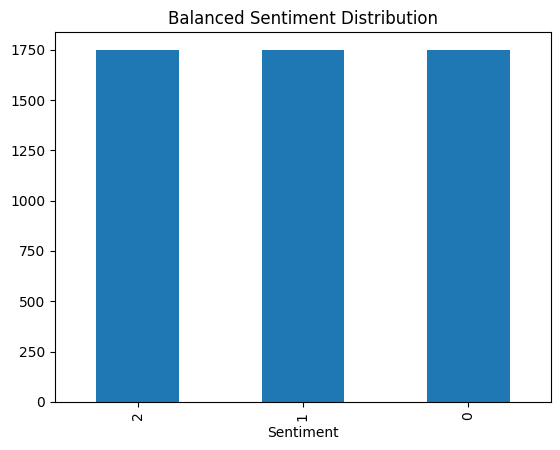

In [17]:
from sklearn.utils import resample

min_count = train_data['Sentiment'].value_counts().min()
dfs = []
for sentiment_label in train_data['Sentiment'].unique():
    df_class = train_data[train_data['Sentiment'] == sentiment_label]
    df_downsampled = resample(df_class, replace=False, n_samples=min_count, random_state=42)
    dfs.append(df_downsampled)

train_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

train_balanced['Sentiment'].value_counts().plot(kind='bar', title='Balanced Sentiment Distribution')

### Dataset Setup Transformer

In [18]:
class HotelDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = 256

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['clean_word']
        labels = self.data.iloc[index][['Sentiment']].values.astype(int)
        encoding = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        # resize the tensors to the same size
        input_ids = nn.functional.pad(input_ids, (0, self.max_length - input_ids.shape[0]), value=0)
        attention_mask = nn.functional.pad(attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0)
        return input_ids, attention_mask, torch.tensor(labels)

In [19]:
model_checkpoint = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
device = torch.device("mps")

# train_dataset = HotelDataset(train_data, tokenizer)
train_dataset = HotelDataset(train_balanced, tokenizer)
test_dataset = HotelDataset(test_data, tokenizer)

In [20]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
class BertClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_checkpoint)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels)

        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)
        return x

In [26]:
num_labels = 3
model = BertClassifier(num_labels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)

num_epochs = 10
n_total_steps = len(train_loader)

In [27]:
for epoch in range(num_epochs):

  for i, batch in enumerate (train_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    optimizer.zero_grad()

    logits = model(input_ids, attention_mask)

    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()


    if (i+1) % 100 == 0:
        print(f'epoch {epoch + 1}/ {num_epochs}, batch {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

epoch 1/ 10, batch 100/164, loss = 0.8612
epoch 2/ 10, batch 100/164, loss = 0.7763
epoch 3/ 10, batch 100/164, loss = 0.3641
epoch 4/ 10, batch 100/164, loss = 0.3226
epoch 5/ 10, batch 100/164, loss = 0.1708
epoch 6/ 10, batch 100/164, loss = 0.0293
epoch 7/ 10, batch 100/164, loss = 0.1827
epoch 8/ 10, batch 100/164, loss = 0.0133
epoch 9/ 10, batch 100/164, loss = 0.0082
epoch 10/ 10, batch 100/164, loss = 0.0457


In [29]:
all_labels = []
all_preds = []

with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for i, batch in enumerate (test_loader):

    input_ids, attention_mask, labels = batch
    input_ids = input_ids.to(device)

    attention_mask = attention_mask.to(device)

    labels = labels.view(-1)
    labels = labels.to(device)

    outputs = model(input_ids, attention_mask)

    _, predictions = torch.max(outputs, 1)

    all_labels.append(labels.cpu().numpy())
    all_preds.append(predictions.cpu().numpy())

all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

print(classification_report(all_labels, all_preds, target_names=["Negatif", "Netral", "Positif"]))
print('Accuracy Score', accuracy_score(all_labels, all_preds))

              precision    recall  f1-score   support

     Negatif       0.86      0.61      0.72       661
      Netral       0.26      0.79      0.39       435
     Positif       0.97      0.75      0.85      3003

    accuracy                           0.73      4099
   macro avg       0.70      0.72      0.65      4099
weighted avg       0.88      0.73      0.78      4099

Accuracy Score 0.7323737496950475


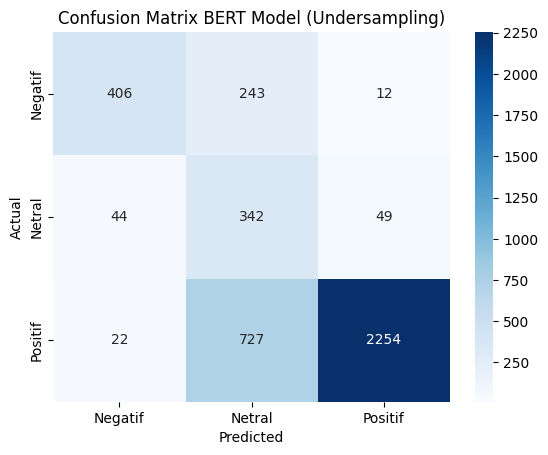

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negatif", "Netral", "Positif"], yticklabels=["Negatif", "Netral", "Positif"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix BERT Model (Undersampling)')
plt.show()